In [63]:
# !pip install speechbrain==1.0.0
# !pip install torch torchaudio

In [64]:
# !pip install librosa 
#!pip install wonderwords



[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


from pathlib import Path 
from pydub import AudioSegment
import glob
from tqdm import tqdm
import IPython.display as display
from IPython.display import Audio
import pandas as pd, numpy as np, matplotlib.pyplot as plt

import torchaudio
import librosa
import librosa.display

In [112]:
from pathlib import Path 
from pydub import AudioSegment
import glob
from tqdm import tqdm
import IPython.display as display
from IPython.display import Audio
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import torchaudio
import librosa
import librosa.display
import wonderwords

/Users/jonas/Library/CloudStorage/OneDrive-UniversityofExeter/sound_recognition/api/.venv/lib/python3.12/site-packages/wonderwords/random_word.py:74: SyntaxWarning: invalid escape sequence '\*'
  """The RandomWord class encapsulates multiple methods dealing with the


In [66]:
# Run only if you havent already diced up the files

import audiosegment

states = ['air', 'vac', 'off']

path = Path("/Users/jonas/Library/CloudStorage/OneDrive-UniversityofExeter/sound_recognition/data/g28_huawei/")
files = list(path.glob("*"))

for state in states:
    file = list((path / state).glob("*.m4a"))[0]
    audio = audiosegment.from_file(file).dice(4)
    for numb, aud in enumerate(audio):
        name = f"{state}_{numb}.wav"
        dirs = path / state / name
        print(dirs)
        aud.export(dirs , format='wav')

/Users/jonas/Library/CloudStorage/OneDrive-UniversityofExeter/sound_recognition/data/g28_huawei/air/air_0.wav
/Users/jonas/Library/CloudStorage/OneDrive-UniversityofExeter/sound_recognition/data/g28_huawei/air/air_1.wav
/Users/jonas/Library/CloudStorage/OneDrive-UniversityofExeter/sound_recognition/data/g28_huawei/air/air_2.wav
/Users/jonas/Library/CloudStorage/OneDrive-UniversityofExeter/sound_recognition/data/g28_huawei/air/air_3.wav
/Users/jonas/Library/CloudStorage/OneDrive-UniversityofExeter/sound_recognition/data/g28_huawei/air/air_4.wav
/Users/jonas/Library/CloudStorage/OneDrive-UniversityofExeter/sound_recognition/data/g28_huawei/air/air_5.wav
/Users/jonas/Library/CloudStorage/OneDrive-UniversityofExeter/sound_recognition/data/g28_huawei/air/air_6.wav
/Users/jonas/Library/CloudStorage/OneDrive-UniversityofExeter/sound_recognition/data/g28_huawei/air/air_7.wav
/Users/jonas/Library/CloudStorage/OneDrive-UniversityofExeter/sound_recognition/data/g28_huawei/air/air_8.wav
/Users/jon

## Inspect training data 

In [67]:
cats = ['air', 'vac', 'off']
files_path = "/Users/jonas/Library/CloudStorage/OneDrive-UniversityofExeter/sound_recognition/data/g28_huawei"
#files_path2 = "/Users/jonas/Library/CloudStorage/OneDrive-UniversityofExeter/sound_recognition/g28"

path = Path(files_path)
#path2 = Path(files_path2)

files = []
for p in path.rglob("*.wav"):
    files.append(str(p))
    #files += glob.glob(f"../data/{cls}/*.wav")
#for p in path2.rglob("*.wav"):
#    files.append(str(p))
#    #files += glob.glob(f"../data/{cls}/*.wav")

In [68]:
print(files)

['/Users/jonas/Library/CloudStorage/OneDrive-UniversityofExeter/sound_recognition/data/g28_huawei/air/air_54.wav', '/Users/jonas/Library/CloudStorage/OneDrive-UniversityofExeter/sound_recognition/data/g28_huawei/air/air_40.wav', '/Users/jonas/Library/CloudStorage/OneDrive-UniversityofExeter/sound_recognition/data/g28_huawei/air/air_41.wav', '/Users/jonas/Library/CloudStorage/OneDrive-UniversityofExeter/sound_recognition/data/g28_huawei/air/air_55.wav', '/Users/jonas/Library/CloudStorage/OneDrive-UniversityofExeter/sound_recognition/data/g28_huawei/air/air_43.wav', '/Users/jonas/Library/CloudStorage/OneDrive-UniversityofExeter/sound_recognition/data/g28_huawei/air/air_57.wav', '/Users/jonas/Library/CloudStorage/OneDrive-UniversityofExeter/sound_recognition/data/g28_huawei/air/air_56.wav', '/Users/jonas/Library/CloudStorage/OneDrive-UniversityofExeter/sound_recognition/data/g28_huawei/air/air_42.wav', '/Users/jonas/Library/CloudStorage/OneDrive-UniversityofExeter/sound_recognition/data/g

In [69]:
df = pd.DataFrame(dict(filepath=files))
df["label"] = df.filepath.apply(lambda x: Path(x).parent.name)
df["name"] = df.filepath.apply(lambda x: Path(x).name)
df["duration"] = df.filepath.apply(lambda x: librosa.get_duration(path=x))
df.sample(5)

,filepath,label,name,duration
18,/Users/jonas/Library/CloudStorage/OneDrive-Uni...,air,air_37.wav,4.0
173,/Users/jonas/Library/CloudStorage/OneDrive-Uni...,off,off_48.wav,4.0
14,/Users/jonas/Library/CloudStorage/OneDrive-Uni...,air,air_45.wav,4.0
82,/Users/jonas/Library/CloudStorage/OneDrive-Uni...,vac,vac_32.wav,4.0
110,/Users/jonas/Library/CloudStorage/OneDrive-Uni...,vac,vac_16.wav,4.0


In [70]:
# drop samples that are to short in duration (< 3.5 secs)
df = df.drop(df[(df.duration < 3.99)].index)
df.duration.value_counts()

duration
4.0    180
Name: count, dtype: int64

In [71]:
# Drop the first sample in all categories
# as first sample often has silence in it
#df_0 = df[df.name.str.contains("_0.wav")]
df = df[~df.name.str.contains("_0.wav")]
df = df[~df.name.str.contains("_31.wav")]


In [72]:
df.label.value_counts()

label
air    58
vac    58
off    58
Name: count, dtype: int64

In [73]:
def get_sample_of(cls: str, random_state=None):
    return df[df.label == cls].sample(random_state=random_state).iloc[0]
    
def play_sample(sample):
    print(sample.filepath, sample.label)
    return display.Audio(sample.filepath, autoplay=True)

def play_sample_of(cls: str, random_state=None):
    sample = get_sample_of(cls, random_state)
    return play_sample(sample)

In [74]:
def plot_spectrogram(filepath, title=None):
    y, sr = librosa.load(filepath)
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel-frequency spectrogram ({title})')
    plt.tight_layout()
    plt.show()

def show_sample(sample, **kwargs):
    plot_spectrogram(sample.filepath, **kwargs)

def show_sample_of(cls: str, random_state=None):
    sample = get_sample_of(cls, random_state)
    return show_sample(sample)

## Train/validation split

Split data into training and validation 

In [75]:
from sklearn.model_selection import train_test_split

In [76]:
train, val = train_test_split(df, stratify=df.label, random_state=0, test_size=0.20)
train.shape, val.shape

((139, 4), (35, 4))

In [77]:
df['isval'] = [i in val.index for i in df.index]

In [78]:
df.isval.value_counts()

isval
False    139
True      35
Name: count, dtype: int64

In [79]:
train.label.value_counts()

label
vac    47
air    46
off    46
Name: count, dtype: int64

In [80]:
val.name

105    vac_49.wav
6      air_56.wav
129    off_25.wav
19     air_23.wav
180    off_29.wav
88     vac_54.wav
109    vac_59.wav
23     air_34.wav
75     vac_25.wav
9      air_52.wav
62     vac_37.wav
71      vac_5.wav
3      air_55.wav
72     vac_35.wav
158    off_42.wav
56      air_2.wav
130    off_19.wav
169     off_9.wav
41     air_28.wav
163     off_3.wav
116    vac_38.wav
114    vac_28.wav
168     off_8.wav
58      air_1.wav
167    off_59.wav
38     air_29.wav
165    off_41.wav
64      vac_7.wav
21     air_36.wav
0      air_54.wav
141    off_22.wav
86     vac_27.wav
181    off_15.wav
24     air_35.wav
143    off_51.wav
Name: name, dtype: object

## Import / download pretrained model (speechbrain urbansound)

In [81]:
import torchaudio
from speechbrain.inference.classifiers import EncoderClassifier
classifier = EncoderClassifier.from_hparams(source="speechbrain/urbansound8k_ecapa", savedir="models/gurbansound8k_ecapa")
out_prob, score, index, text_lab = classifier.classify_file('speechbrain/urbansound8k_ecapa/dog_bark.wav')
print(text_lab)

['dog_bark']


# Check that our files are compatible with the downloaded classifier 

In [82]:
import random
rand = random.randint(0,(len(cats) - 1))
sample = get_sample_of(cats[rand], random_state=1)
classifier.classify_file(sample.filepath)

(tensor([[-0.2448, -0.2221,  0.4067, -0.4413, -0.0444, -0.1651,  0.5004,  0.3076,
           0.1879, -0.1033]]),
 tensor([0.5004]),
 tensor([6]),
 ['engine_idling'])

## Convert audio to tensors for training 

In [83]:
import torchaudio
import torch

In [84]:
df.iloc[0].filepath

'/Users/jonas/Library/CloudStorage/OneDrive-UniversityofExeter/sound_recognition/data/g28_huawei/air/air_54.wav'

different samples have different length tensor (longer or shorter time series) 

In [85]:
from numpy import random
import numpy as np
from torchaudio import transforms
from torchaudio.io import AudioEffector
import matplotlib.pyplot as plt

class AudioUtil():
    #---------------
    # Load an audio file. Return the signal as a tensor and the sample rate
    #---------------
    @staticmethod
    def open(audio_file):
        sig, sr = torchaudio.load(audio_file)
        
        return (sig, sr)

    @staticmethod
    def apply_gain(aud, sig_max=0.9):
        sig, sr = aud
        gn = sig_max / sig.max()

        transform = transforms.Vol(gain=gn, gain_type="amplitude")
        
        sig_amp = transform(sig)
        
        return (sig_amp, sr)
    
    #---------------
    # Convert soundfile to desired number of channels
    #---------------
    @staticmethod
    def rechannel(aud, new_channel):
        
        sig, sr = aud
        
        if sig.shape[0] == new_channel:
            #Nothing todo
            return aud
        
        if (new_channel == 1):
            #Convert stereo to mono by selecting only the first channel
            resig = sig[:1, :]
        else:
            #Convert from mono to sterio by duplicating the first channel
            resig = torch.cat([sig,sig])
        return ((resig, sr))
    
    #---------------
    #Resample to make sure samplerate is the same for all files - resample applies to one channel at a time
    #---------------
    @staticmethod
    def resample(aud, newsr):
        
        sig, sr = aud
        
        if (sr == newsr):
            #do nothing
            return aud
        
        num_channels = sig.shape[0]
        
        #resample first channel
        resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
        
        if (num_channels > 1):
            #Resample the second channel and merge both
            retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
            resig = torch.cat([resig, retwo])
            
        return ((resig, newsr))
    
    
    #-----------------
    #Pad or turncate the signal to be off a standard length in milliseconds
    #-----------------
    @staticmethod
    def pad_trunc(aud, max_ms):

        sig, sr = aud
        num_rows, sig_len = sig.shape
        max_len = sr * max_ms / 1000
        
        if (sig_len > max_len):
            #Turncate the signal to the given length
            print(f"Signal length larger than max length {sig_len} > {max_len}")
            sig = sig[:,:max_len]
        elif (sig_len < max_len):
            print(f"Signal length smaller than max length {sig_len} < {max_len}")

            pad_begin_len = random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len
            
            #pad with zeroes
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))
            
            sig = torch.cat((pad_begin, sig, pad_end), 1)
        
        return (sig, sr)

    #--------------------
    #Shift the signal by a random bit, end of signal is wrapped around 
    #to beginning
    #--------------------
    @staticmethod
    def time_shift(aud, shift_limit):
        sig, sr = aud
        
        _, sig_len = sig.shape
        shift_amt = int(random.random() * shift_limit * sig_len)
        return (sig.roll(shift_amt), sr)

    #--------------------
    #Add eccho or vibrato to the signal. 
    #This method is intented for the generation of synthetic data,
    #using a limited dataset. 
    #--------------------
    @staticmethod
    def add_rand_effect(aud):
        sig, sr = aud    
        effect = random.randint(0,1)
        if effect ==0:
            delay = random.randint(40,100)
            decay = round(random.uniform(0.2,0.7), 2)
            effect = "aecho=in_gain=0.8:out_gain=0.9:delays={}:decays={}".format(delay, decay)
        elif effect == 1:
            freq = random.randint(9,15)
            decay = round(random.uniform(0.15,0.4), 2)
            effect = "vibrato=f={}:d={}".format(freq, decay)
        effector = AudioEffector(effect=effect, pad_end=False)
        sig_ef = effector.apply(sig.T, int(sr)) # int(sr)
        sig_ef = sig_ef.T

        return (sig_ef, sr)
    
    #----------------------------------
    #Genetate spectrogram
    #----------------------------------
    @staticmethod
    def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
        sig,sr = aud
        top_db = 80
        
        #spec has shape [channel, n_mels, time]
        spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)
        
        #convert to db
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
        
        return spec
    
    
    #Augment the spectrogram by masking out some sections of it in both the frequency
    #dimencion (Horizontal) and the time dimension (vertical bars)
    
    @staticmethod
    def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
        _, n_mels, n_steps = spec.shape
        mask_value = spec.mean()
        aug_spec = spec
        
        freq_mask_param = max_mask_pct * n_mels
        for _ in range(n_freq_masks):
            aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)
        
        time_mask_param = max_mask_pct * n_steps
        for _ in range(n_time_masks):
            aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)
        
        return np.absolute(aug_spec) # Jonas added np.absolute
    
        

In [86]:
from speechbrain.dataio.preprocess import AudioNormalizer

class LoadTransform():
    def __init__(self):
        self.duration = 4000
        self.sr_classifier = 16000 # this is the required sample rate for the classifier
        self.channel = 1
        self.shift_pct = 0.3
        self.audio_normalizer = AudioNormalizer(sample_rate=self.sr_classifier)
    
    def load_audio(self, file_path, return_spectrogram=False):
        signal = AudioUtil.open(file_path)
        #print(f"Audio tensor shape ={signal[0].shape}")

        signal = AudioUtil.rechannel(signal, self.channel)
        #print(f"rechan tensor shape ={signal[0].shape}")

        signal = AudioUtil.pad_trunc(signal, self.duration)
        #print(f"dur_aud tensor shape ={signal[0].shape}")

        signal = AudioUtil.time_shift(signal, self.shift_pct)
        #print(f"ts_aud tensor shape ={signal[0].shape}")
    
        if return_spectrogram:
            return AudioUtil.spectro_gram(signal)

        signal, sr = signal[0].T, signal[1]
        #print(f"Audio sample rate ={sr}")


        return self.audio_normalizer(signal, sr)

In [87]:
from torch.utils.data import DataLoader, Dataset, random_split
#----------------
#Sound dataset
#----------------
    
class SoundDS(Dataset):
    def __init__(self, X, y):
        #self.df = df
        #self.data_paths = data_paths
        self.X = X
        self.y = y
        self.duration = 4000
        self.sr = 44100
        self.channel = 2
        self.shift_pct = 0.3
    
    #------------------
    #Number of items in dataset
    #------------------
    def __len__(self):
        return len(self.y)

    #------------------
    #Get i'th item in dataset
    #------------------
    def __getitem__(self, idx):
        # Get the class ID  
        #class_id = self.df.loc[idx, 'label']
        #audio_file = str(self.df.loc[idx, 'filepath'])
        audio_file = self.X[idx]
        aud = AudioUtil.open(audio_file)
        reaud = AudioUtil.resample(aud, self.sr)
        rechan = AudioUtil.rechannel(reaud, self.channel)
        dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
        ts_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
        y = torch.zeros(3)
        y[cats.index(self.y[idx])] = 1.
        #sgram = AudioUtil.spectro_gram(dur_aud, n_mels=64, n_fft=1024, hop_len=None)
        return ts_aud, y


the classifier's `load_audio` function does some extra stuff like normalization, so let's use that 


In [88]:
filep = df.iloc[0].filepath
filep

'/Users/jonas/Library/CloudStorage/OneDrive-UniversityofExeter/sound_recognition/data/g28_huawei/air/air_54.wav'

In [89]:
tens = classifier.load_audio(sample.filepath)
Transform = LoadTransform()
tens2 = Transform.load_audio(sample.filepath)
print(f"Classifier tensor shape = {tens.shape}")
print(f"Transfrom tensor shape = {tens2.shape}")


Classifier tensor shape = torch.Size([64000])
Transfrom tensor shape = torch.Size([64000])


In [90]:
tens2.unsqueeze(0).shape

torch.Size([1, 64000])

In [91]:
rel_length =  torch.tensor([1.])
enc = classifier.encode_batch(tens2.unsqueeze(0), rel_length)
enc.shape

torch.Size([1, 1, 192])

In [92]:
# probabilities of each class
preds = classifier.mods.classifier(enc).squeeze(1); preds

tensor([[-0.2511, -0.2226,  0.4351, -0.4299, -0.0444, -0.1714,  0.4929,  0.3036,
          0.1701, -0.0985]])

In [93]:
# batch of preds, but just 1 in the batch 
preds.shape

torch.Size([1, 10])

In [94]:
# check that our work agrees with the full implementation 
classifier.classify_file(str(sample.filepath))

(tensor([[-0.2448, -0.2221,  0.4067, -0.4413, -0.0444, -0.1651,  0.5004,  0.3076,
           0.1879, -0.1033]]),
 tensor([0.5004]),
 tensor([6]),
 ['engine_idling'])

## Create dataset 

In [95]:
from torch.utils.data import Dataset
import torch.nn.functional as F

In [96]:
cats

['air', 'vac', 'off']

In [97]:
train.head(3)

,filepath,label,name,duration
40,/Users/jonas/Library/CloudStorage/OneDrive-Uni...,air,air_14.wav,4.0
11,/Users/jonas/Library/CloudStorage/OneDrive-Uni...,air,air_47.wav,4.0
125,/Users/jonas/Library/CloudStorage/OneDrive-Uni...,off,off_32.wav,4.0


In [98]:
from functools import cache

class ApplianceDS(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y 
    def __len__(self): return len(self.y)
    
    @cache
    def __getitem__(self, i):
        y = torch.zeros(len(cats))
        y[cats.index(self.y[i])] = 1.
        return self.X[i], y

In [99]:

#Xtrain = torch.stack([classifier.load_audio(fp) for fp in train.filepath])
#Xtrain = torch.stack([classifier.load_audio(fp) for fp in train.filepath])
Xtrain = torch.stack([Transform.load_audio(fp) for fp in train.filepath])
Xval = torch.stack([Transform.load_audio(fp) for fp in val.filepath])
#Xtest = torch.stack([Transform.load_audio(fp) for fp in test.filepath])

ytrain = list(train.label)
yval = list(val.label)
#ytest = list(test.label)
Xtrain.shape, Xval.shape


# (torch.Size([59, 64000]), torch.Size([13, 64000]))


(torch.Size([139, 64000]), torch.Size([35, 64000]))

In [100]:
yval

['vac',
 'air',
 'off',
 'air',
 'off',
 'vac',
 'vac',
 'air',
 'vac',
 'air',
 'vac',
 'vac',
 'air',
 'vac',
 'off',
 'air',
 'off',
 'off',
 'air',
 'off',
 'vac',
 'vac',
 'off',
 'air',
 'off',
 'air',
 'off',
 'vac',
 'air',
 'air',
 'off',
 'vac',
 'off',
 'air',
 'off']

In [101]:
train_ds = ApplianceDS(Xtrain, ytrain)
val_ds = ApplianceDS(Xval, yval)
#test_ds = ApplianceDS(Xtest, ytest)

In [102]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=8, shuffle=True)
# we don't need batches for the validation set so just put into a big batch 
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=8, shuffle=True)
#test_dl = torch.utils.data.DataLoader(test_ds, batch_size=len(test_ds), shuffle=True)

In [103]:
Xval, yval = next(iter(val_dl))
Xval.shape, yval.shape

(torch.Size([8, 64000]), torch.Size([8, 3]))

In [104]:
def reset_weights():
    classifier.mods.classifier.weight = torch.nn.Parameter(torch.FloatTensor(len(cats), 192))
    torch.nn.init.xavier_uniform_(classifier.mods.classifier.weight)
reset_weights()

In [105]:
for param in classifier.mods.classifier.parameters():
    print(param.requires_grad)

True


In [106]:
classifier.mods.compute_features

Fbank(
  (compute_STFT): STFT()
  (compute_fbanks): Filterbank()
  (compute_deltas): Deltas()
  (context_window): ContextWindow()
)

In [107]:
for mod in classifier.mods:
    print(mod)
    for p in classifier.mods.__getattr__(mod).parameters():
        print(mod, p.requires_grad)
        break

compute_features
mean_var_norm
embedding_model
embedding_model False
classifier
classifier True


In [108]:
loss_fn = torch.nn.CrossEntropyLoss()

"""

train_loss = []
val_loss = []
reset_weights()
optimizer = torch.optim.Adam(classifier.mods.classifier.parameters(), lr=0.002) # changed from 0.001
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)
for epoch in tqdm(range(100)):
    losses = []
    for batch_idx, (X, y) in enumerate(train_dl):
        logits, confidences, classes, decoded_classes = classifier(X)
        loss = loss_fn(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    train_loss.append(np.mean(losses))
    
    val_preds, *_ = classifier(Xval)    
    val_loss_ = loss_fn(val_preds, yval)
    scheduler.step(val_loss_)
    val_loss.append(val_loss_.item())

    print(f"Epoch {epoch}: Train Loss: {train_loss[-1]:.4f}, Validation Loss: {val_loss[-1]:.4f}, Learning rate: {optimizer.param_groups[0]['lr']}")


    

In [109]:
MODEL_TAG = ""
train_loss = []
val_loss = []

# Reset weights before training
reset_weights()

# Optimizer with modified learning rate
optimizer = torch.optim.Adam(classifier.mods.classifier.parameters(), lr=0.0009)

# Scheduler to reduce learning rate on plateau
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

# Training loop
for epoch in tqdm(range(100)):
    # Set model to training mode
    classifier.train()
    losses = []
    
    for batch_idx, (X, y) in enumerate(train_dl):
        logits, confidences, classes, decoded_classes = classifier(X)
        loss = loss_fn(logits, y)
        
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()        # Backpropagate
        optimizer.step()       # Update parameters
        
        losses.append(loss.item())
    
    train_loss.append(np.mean(losses))

    # Validation step
    classifier.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for validation
        val_preds, *_ = classifier(Xval)
        val_loss_ = loss_fn(val_preds, yval)
        val_loss.append(val_loss_.item())
    
    # Print loss
    print(f"Epoch {epoch}: Train Loss: {train_loss[-1]:.4f}, Validation Loss: {val_loss[-1]:.4f}")

    # Step the scheduler with the validation loss
    scheduler.step(val_loss_)

    # Optional: print the current learning rate
    for param_group in optimizer.param_groups:
        print(f"Learning Rate: {param_group['lr']}")
r = wonderwords.RandomWord()
MODEL_TAG = f'{r.word(include_categories=["adjective"])}_{r.word()}'

  1%|          | 1/100 [00:05<09:12,  5.58s/it]

Epoch 0: Train Loss: 1.0745, Validation Loss: 1.0649
Learning Rate: 0.0009


  2%|▏         | 2/100 [00:11<09:37,  5.89s/it]

Epoch 1: Train Loss: 1.0320, Validation Loss: 1.0057
Learning Rate: 0.0009


  3%|▎         | 3/100 [00:17<09:48,  6.06s/it]

Epoch 2: Train Loss: 0.9943, Validation Loss: 0.9488
Learning Rate: 0.0009


  4%|▍         | 4/100 [00:23<09:24,  5.89s/it]

Epoch 3: Train Loss: 0.9477, Validation Loss: 0.9122
Learning Rate: 0.0009


  5%|▌         | 5/100 [00:28<09:03,  5.72s/it]

Epoch 4: Train Loss: 0.9151, Validation Loss: 0.8731
Learning Rate: 0.0009


  6%|▌         | 6/100 [00:34<08:37,  5.51s/it]

Epoch 5: Train Loss: 0.8892, Validation Loss: 0.8384
Learning Rate: 0.0009


  7%|▋         | 7/100 [00:39<08:16,  5.34s/it]

Epoch 6: Train Loss: 0.8357, Validation Loss: 0.8089
Learning Rate: 0.0009


  8%|▊         | 8/100 [00:44<08:09,  5.32s/it]

Epoch 7: Train Loss: 0.8455, Validation Loss: 0.7775
Learning Rate: 0.0009


  9%|▉         | 9/100 [00:49<07:56,  5.23s/it]

Epoch 8: Train Loss: 0.8197, Validation Loss: 0.7538
Learning Rate: 0.0009


 10%|█         | 10/100 [00:54<07:52,  5.25s/it]

Epoch 9: Train Loss: 0.7890, Validation Loss: 0.7462
Learning Rate: 0.0009


 11%|█         | 11/100 [01:00<07:50,  5.28s/it]

Epoch 10: Train Loss: 0.7682, Validation Loss: 0.7230
Learning Rate: 0.0009


 12%|█▏        | 12/100 [01:05<07:42,  5.26s/it]

Epoch 11: Train Loss: 0.7724, Validation Loss: 0.7095
Learning Rate: 0.0009


 13%|█▎        | 13/100 [01:10<07:33,  5.21s/it]

Epoch 12: Train Loss: 0.7280, Validation Loss: 0.6971
Learning Rate: 0.0009


 14%|█▍        | 14/100 [01:15<07:22,  5.15s/it]

Epoch 13: Train Loss: 0.7532, Validation Loss: 0.6793
Learning Rate: 0.0009


 15%|█▌        | 15/100 [01:20<07:16,  5.13s/it]

Epoch 14: Train Loss: 0.7286, Validation Loss: 0.6732
Learning Rate: 0.0009


 16%|█▌        | 16/100 [01:25<07:09,  5.11s/it]

Epoch 15: Train Loss: 0.7146, Validation Loss: 0.6643
Learning Rate: 0.0009


 17%|█▋        | 17/100 [01:30<07:06,  5.14s/it]

Epoch 16: Train Loss: 0.7459, Validation Loss: 0.6699
Learning Rate: 0.0009


 18%|█▊        | 18/100 [01:36<07:07,  5.21s/it]

Epoch 17: Train Loss: 0.7386, Validation Loss: 0.6613
Learning Rate: 0.0009


 19%|█▉        | 19/100 [01:41<06:59,  5.18s/it]

Epoch 18: Train Loss: 0.7001, Validation Loss: 0.6477
Learning Rate: 0.0009


 20%|██        | 20/100 [01:46<07:00,  5.25s/it]

Epoch 19: Train Loss: 0.6937, Validation Loss: 0.6493
Learning Rate: 0.0009


 21%|██        | 21/100 [01:51<06:49,  5.18s/it]

Epoch 20: Train Loss: 0.6800, Validation Loss: 0.6467
Learning Rate: 0.0009


 22%|██▏       | 22/100 [01:56<06:45,  5.20s/it]

Epoch 21: Train Loss: 0.6899, Validation Loss: 0.6413
Learning Rate: 0.0009


 23%|██▎       | 23/100 [02:01<06:38,  5.17s/it]

Epoch 22: Train Loss: 0.6813, Validation Loss: 0.6442
Learning Rate: 0.0009


 24%|██▍       | 24/100 [02:07<06:31,  5.15s/it]

Epoch 23: Train Loss: 0.6953, Validation Loss: 0.6500
Learning Rate: 0.0009


 25%|██▌       | 25/100 [02:12<06:22,  5.11s/it]

Epoch 24: Train Loss: 0.6948, Validation Loss: 0.6426
Learning Rate: 0.0009


 26%|██▌       | 26/100 [02:17<06:18,  5.12s/it]

Epoch 25: Train Loss: 0.6740, Validation Loss: 0.6420
Learning Rate: 0.0009


 27%|██▋       | 27/100 [02:22<06:15,  5.14s/it]

Epoch 26: Train Loss: 0.7028, Validation Loss: 0.6443
Learning Rate: 0.0009


 28%|██▊       | 28/100 [02:27<06:11,  5.16s/it]

Epoch 27: Train Loss: 0.6721, Validation Loss: 0.6434
Learning Rate: 9e-05


 29%|██▉       | 29/100 [02:32<06:03,  5.13s/it]

Epoch 28: Train Loss: 0.6847, Validation Loss: 0.6431
Learning Rate: 9e-05


 30%|███       | 30/100 [02:38<06:05,  5.22s/it]

Epoch 29: Train Loss: 0.6737, Validation Loss: 0.6451
Learning Rate: 9e-05


 31%|███       | 31/100 [02:43<06:09,  5.35s/it]

Epoch 30: Train Loss: 0.6816, Validation Loss: 0.6315
Learning Rate: 9e-05


 32%|███▏      | 32/100 [02:49<06:06,  5.39s/it]

Epoch 31: Train Loss: 0.6799, Validation Loss: 0.6401
Learning Rate: 9e-05


 33%|███▎      | 33/100 [02:54<05:59,  5.36s/it]

Epoch 32: Train Loss: 0.6761, Validation Loss: 0.6436
Learning Rate: 9e-05


 34%|███▍      | 34/100 [02:59<05:48,  5.28s/it]

Epoch 33: Train Loss: 0.6801, Validation Loss: 0.6399
Learning Rate: 9e-05


 35%|███▌      | 35/100 [03:04<05:38,  5.21s/it]

Epoch 34: Train Loss: 0.6800, Validation Loss: 0.6367
Learning Rate: 9e-05


 36%|███▌      | 36/100 [03:09<05:33,  5.21s/it]

Epoch 35: Train Loss: 0.6788, Validation Loss: 0.6413
Learning Rate: 9e-05


 37%|███▋      | 37/100 [03:14<05:22,  5.12s/it]

Epoch 36: Train Loss: 0.6772, Validation Loss: 0.6300
Learning Rate: 9e-05


 38%|███▊      | 38/100 [03:19<05:17,  5.12s/it]

Epoch 37: Train Loss: 0.6796, Validation Loss: 0.6366
Learning Rate: 9e-05


 39%|███▉      | 39/100 [03:24<05:11,  5.10s/it]

Epoch 38: Train Loss: 0.6921, Validation Loss: 0.6361
Learning Rate: 9e-05


 40%|████      | 40/100 [03:30<05:08,  5.13s/it]

Epoch 39: Train Loss: 0.6844, Validation Loss: 0.6317
Learning Rate: 9e-05


 41%|████      | 41/100 [03:35<05:02,  5.12s/it]

Epoch 40: Train Loss: 0.6901, Validation Loss: 0.6329
Learning Rate: 9e-05


 42%|████▏     | 42/100 [03:41<05:14,  5.42s/it]

Epoch 41: Train Loss: 0.6867, Validation Loss: 0.6296
Learning Rate: 9e-05


 43%|████▎     | 43/100 [03:47<05:13,  5.50s/it]

Epoch 42: Train Loss: 0.6635, Validation Loss: 0.6384
Learning Rate: 9e-05


 44%|████▍     | 44/100 [03:52<05:04,  5.43s/it]

Epoch 43: Train Loss: 0.6785, Validation Loss: 0.6323
Learning Rate: 9e-05


 45%|████▌     | 45/100 [03:57<04:52,  5.32s/it]

Epoch 44: Train Loss: 0.6620, Validation Loss: 0.6328
Learning Rate: 9e-05


 46%|████▌     | 46/100 [04:02<04:45,  5.29s/it]

Epoch 45: Train Loss: 0.7093, Validation Loss: 0.6323
Learning Rate: 9e-05


 47%|████▋     | 47/100 [04:07<04:35,  5.19s/it]

Epoch 46: Train Loss: 0.7167, Validation Loss: 0.6368
Learning Rate: 9e-05


 48%|████▊     | 48/100 [04:12<04:27,  5.14s/it]

Epoch 47: Train Loss: 0.6857, Validation Loss: 0.6357
Learning Rate: 9e-06


 49%|████▉     | 49/100 [04:17<04:18,  5.07s/it]

Epoch 48: Train Loss: 0.7018, Validation Loss: 0.6360
Learning Rate: 9e-06


 50%|█████     | 50/100 [04:22<04:17,  5.16s/it]

Epoch 49: Train Loss: 0.6570, Validation Loss: 0.6344
Learning Rate: 9e-06


 51%|█████     | 51/100 [04:28<04:16,  5.23s/it]

Epoch 50: Train Loss: 0.6833, Validation Loss: 0.6372
Learning Rate: 9e-06


 52%|█████▏    | 52/100 [04:33<04:08,  5.17s/it]

Epoch 51: Train Loss: 0.7145, Validation Loss: 0.6406
Learning Rate: 9e-06


 53%|█████▎    | 53/100 [04:38<04:01,  5.13s/it]

Epoch 52: Train Loss: 0.6790, Validation Loss: 0.6402
Learning Rate: 9e-06


 54%|█████▍    | 54/100 [04:43<03:55,  5.13s/it]

Epoch 53: Train Loss: 0.6841, Validation Loss: 0.6336
Learning Rate: 9.000000000000001e-07


 55%|█████▌    | 55/100 [04:49<03:59,  5.33s/it]

Epoch 54: Train Loss: 0.6719, Validation Loss: 0.6354
Learning Rate: 9.000000000000001e-07


 56%|█████▌    | 56/100 [04:54<03:50,  5.24s/it]

Epoch 55: Train Loss: 0.6801, Validation Loss: 0.6354
Learning Rate: 9.000000000000001e-07


 57%|█████▋    | 57/100 [04:59<03:46,  5.26s/it]

Epoch 56: Train Loss: 0.6947, Validation Loss: 0.6355
Learning Rate: 9.000000000000001e-07


 58%|█████▊    | 58/100 [05:04<03:40,  5.26s/it]

Epoch 57: Train Loss: 0.6865, Validation Loss: 0.6379
Learning Rate: 9.000000000000001e-07


 59%|█████▉    | 59/100 [05:10<03:36,  5.28s/it]

Epoch 58: Train Loss: 0.6709, Validation Loss: 0.6372
Learning Rate: 9.000000000000001e-07


 60%|██████    | 60/100 [05:15<03:30,  5.26s/it]

Epoch 59: Train Loss: 0.7016, Validation Loss: 0.6364
Learning Rate: 9.000000000000001e-08


 61%|██████    | 61/100 [05:20<03:23,  5.21s/it]

Epoch 60: Train Loss: 0.6653, Validation Loss: 0.6349
Learning Rate: 9.000000000000001e-08


 62%|██████▏   | 62/100 [05:25<03:17,  5.18s/it]

Epoch 61: Train Loss: 0.6867, Validation Loss: 0.6390
Learning Rate: 9.000000000000001e-08


 63%|██████▎   | 63/100 [05:30<03:10,  5.16s/it]

Epoch 62: Train Loss: 0.6845, Validation Loss: 0.6321
Learning Rate: 9.000000000000001e-08


 64%|██████▍   | 64/100 [05:36<03:10,  5.29s/it]

Epoch 63: Train Loss: 0.6837, Validation Loss: 0.6317
Learning Rate: 9.000000000000001e-08


 65%|██████▌   | 65/100 [05:41<03:04,  5.27s/it]

Epoch 64: Train Loss: 0.6804, Validation Loss: 0.6340
Learning Rate: 9.000000000000001e-08


 66%|██████▌   | 66/100 [05:46<02:57,  5.23s/it]

Epoch 65: Train Loss: 0.6934, Validation Loss: 0.6322
Learning Rate: 9.000000000000001e-09


 67%|██████▋   | 67/100 [05:51<02:51,  5.18s/it]

Epoch 66: Train Loss: 0.6783, Validation Loss: 0.6345
Learning Rate: 9.000000000000001e-09


 68%|██████▊   | 68/100 [05:57<02:47,  5.23s/it]

Epoch 67: Train Loss: 0.6814, Validation Loss: 0.6399
Learning Rate: 9.000000000000001e-09


 69%|██████▉   | 69/100 [06:02<02:45,  5.32s/it]

Epoch 68: Train Loss: 0.6718, Validation Loss: 0.6308
Learning Rate: 9.000000000000001e-09


 70%|███████   | 70/100 [06:08<02:41,  5.40s/it]

Epoch 69: Train Loss: 0.6910, Validation Loss: 0.6415
Learning Rate: 9.000000000000001e-09


 71%|███████   | 71/100 [06:13<02:37,  5.44s/it]

Epoch 70: Train Loss: 0.6845, Validation Loss: 0.6418
Learning Rate: 9.000000000000001e-09


 72%|███████▏  | 72/100 [06:19<02:32,  5.44s/it]

Epoch 71: Train Loss: 0.7038, Validation Loss: 0.6293
Learning Rate: 9.000000000000001e-09


 73%|███████▎  | 73/100 [06:24<02:25,  5.40s/it]

Epoch 72: Train Loss: 0.7081, Validation Loss: 0.6323
Learning Rate: 9.000000000000001e-09


 74%|███████▍  | 74/100 [06:29<02:17,  5.28s/it]

Epoch 73: Train Loss: 0.6690, Validation Loss: 0.6335
Learning Rate: 9.000000000000001e-09


 75%|███████▌  | 75/100 [06:34<02:10,  5.21s/it]

Epoch 74: Train Loss: 0.6866, Validation Loss: 0.6379
Learning Rate: 9.000000000000001e-09


 76%|███████▌  | 76/100 [06:39<02:04,  5.19s/it]

Epoch 75: Train Loss: 0.6926, Validation Loss: 0.6368
Learning Rate: 9.000000000000001e-09


 77%|███████▋  | 77/100 [06:44<01:58,  5.17s/it]

Epoch 76: Train Loss: 0.6803, Validation Loss: 0.6361
Learning Rate: 9.000000000000001e-09


 78%|███████▊  | 78/100 [06:50<01:54,  5.22s/it]

Epoch 77: Train Loss: 0.6675, Validation Loss: 0.6372
Learning Rate: 9.000000000000001e-09


 79%|███████▉  | 79/100 [06:55<01:49,  5.21s/it]

Epoch 78: Train Loss: 0.6796, Validation Loss: 0.6356
Learning Rate: 9.000000000000001e-09


 80%|████████  | 80/100 [07:00<01:43,  5.16s/it]

Epoch 79: Train Loss: 0.6915, Validation Loss: 0.6337
Learning Rate: 9.000000000000001e-09


 81%|████████  | 81/100 [07:05<01:37,  5.13s/it]

Epoch 80: Train Loss: 0.6748, Validation Loss: 0.6314
Learning Rate: 9.000000000000001e-09


 82%|████████▏ | 82/100 [07:10<01:33,  5.17s/it]

Epoch 81: Train Loss: 0.6684, Validation Loss: 0.6323
Learning Rate: 9.000000000000001e-09


 83%|████████▎ | 83/100 [07:15<01:27,  5.13s/it]

Epoch 82: Train Loss: 0.6679, Validation Loss: 0.6392
Learning Rate: 9.000000000000001e-09


 84%|████████▍ | 84/100 [07:20<01:21,  5.11s/it]

Epoch 83: Train Loss: 0.6904, Validation Loss: 0.6381
Learning Rate: 9.000000000000001e-09


 85%|████████▌ | 85/100 [07:25<01:16,  5.11s/it]

Epoch 84: Train Loss: 0.6825, Validation Loss: 0.6402
Learning Rate: 9.000000000000001e-09


 86%|████████▌ | 86/100 [07:30<01:11,  5.09s/it]

Epoch 85: Train Loss: 0.6806, Validation Loss: 0.6328
Learning Rate: 9.000000000000001e-09


 87%|████████▋ | 87/100 [07:35<01:06,  5.08s/it]

Epoch 86: Train Loss: 0.6721, Validation Loss: 0.6457
Learning Rate: 9.000000000000001e-09


 88%|████████▊ | 88/100 [07:41<01:00,  5.08s/it]

Epoch 87: Train Loss: 0.6783, Validation Loss: 0.6380
Learning Rate: 9.000000000000001e-09


 89%|████████▉ | 89/100 [07:46<00:56,  5.18s/it]

Epoch 88: Train Loss: 0.6941, Validation Loss: 0.6259
Learning Rate: 9.000000000000001e-09


 90%|█████████ | 90/100 [07:51<00:51,  5.15s/it]

Epoch 89: Train Loss: 0.6733, Validation Loss: 0.6346
Learning Rate: 9.000000000000001e-09


 91%|█████████ | 91/100 [07:56<00:46,  5.19s/it]

Epoch 90: Train Loss: 0.6995, Validation Loss: 0.6321
Learning Rate: 9.000000000000001e-09


 92%|█████████▏| 92/100 [08:01<00:41,  5.15s/it]

Epoch 91: Train Loss: 0.6845, Validation Loss: 0.6313
Learning Rate: 9.000000000000001e-09


 93%|█████████▎| 93/100 [08:07<00:35,  5.14s/it]

Epoch 92: Train Loss: 0.6748, Validation Loss: 0.6361
Learning Rate: 9.000000000000001e-09


 94%|█████████▍| 94/100 [08:12<00:30,  5.10s/it]

Epoch 93: Train Loss: 0.6708, Validation Loss: 0.6377
Learning Rate: 9.000000000000001e-09


 95%|█████████▌| 95/100 [08:17<00:25,  5.09s/it]

Epoch 94: Train Loss: 0.6673, Validation Loss: 0.6355
Learning Rate: 9.000000000000001e-09


 96%|█████████▌| 96/100 [08:22<00:20,  5.13s/it]

Epoch 95: Train Loss: 0.7034, Validation Loss: 0.6347
Learning Rate: 9.000000000000001e-09


 97%|█████████▋| 97/100 [08:27<00:15,  5.09s/it]

Epoch 96: Train Loss: 0.6892, Validation Loss: 0.6321
Learning Rate: 9.000000000000001e-09


 98%|█████████▊| 98/100 [08:32<00:10,  5.08s/it]

Epoch 97: Train Loss: 0.6650, Validation Loss: 0.6333
Learning Rate: 9.000000000000001e-09


 99%|█████████▉| 99/100 [08:37<00:05,  5.14s/it]

Epoch 98: Train Loss: 0.6704, Validation Loss: 0.6303
Learning Rate: 9.000000000000001e-09


100%|██████████| 100/100 [08:42<00:00,  5.23s/it]

Epoch 99: Train Loss: 0.6640, Validation Loss: 0.6352
Learning Rate: 9.000000000000001e-09


NameError: name 'wonderwords' is not defined

In [113]:
r = wonderwords.RandomWord()
MODEL_TAG = f'{r.word(include_categories=["adjective"])}_{r.word()}'

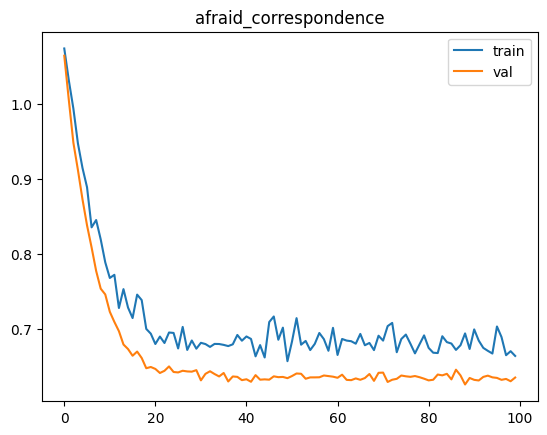

In [114]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['train','val'])
plt.title(MODEL_TAG)
plt.show();

### Validation accuracy 

In [115]:
cats

['air', 'vac', 'off']

In [116]:
preds, *rest = classifier(Xval)

In [117]:
preds.argmax(axis=1)

tensor([0, 1, 0, 1, 0, 1, 1, 2])

In [118]:
yval.argmax(axis=1)

tensor([0, 1, 0, 1, 0, 1, 1, 2])

In [119]:
(preds.argmax(axis=1) == yval.argmax(axis=1)).float().mean()

tensor(1.)

### Train accuracy 

In [120]:
torch.tensor([cats.index(val) for val in ytrain])

tensor([0, 0, 2, 1, 2, 0, 1, 2, 0, 2, 1, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 0, 1, 2,
        1, 0, 1, 2, 1, 2, 1, 2, 1, 1, 0, 2, 1, 2, 1, 2, 0, 1, 0, 1, 2, 1, 2, 0,
        0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 2, 0, 0, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 0,
        0, 1, 1, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 1, 0, 2, 1, 1, 0, 2, 2, 2, 1,
        0, 2, 0, 2, 2, 1, 2, 0, 1, 0, 1, 0, 0, 1, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0,
        2, 2, 1, 1, 1, 0, 1, 0, 2, 1, 1, 1, 0, 1, 0, 2, 1, 1, 2])

In [121]:
train_preds, *rest = classifier(Xtrain)
train_preds.argmax(axis=1)

tensor([0, 0, 2, 1, 2, 0, 1, 2, 0, 2, 1, 2, 2, 2, 0, 0, 0, 2, 2, 0, 2, 0, 1, 2,
        1, 0, 1, 2, 1, 2, 1, 2, 1, 1, 0, 2, 1, 2, 1, 2, 0, 1, 0, 1, 2, 1, 2, 0,
        0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 2, 0, 0, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 0,
        0, 1, 1, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 1, 0, 2, 1, 1, 0, 2, 2, 2, 1,
        0, 2, 0, 2, 2, 1, 2, 0, 1, 0, 1, 0, 0, 1, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0,
        2, 2, 1, 1, 1, 0, 1, 0, 2, 1, 1, 1, 0, 1, 0, 2, 1, 1, 2])

In [122]:
(torch.tensor([cats.index(val) for val in ytrain]) == train_preds.argmax(axis=1)).float().mean()

tensor(0.9856)

# Test accuracy

In [123]:
xcvxcvytest

NameError: name 'xcvxcvytest' is not defined

In [ ]:
torch.tensor([cats.index(val) for val in ytest])
test_preds, *rest = classifier(Xtest)
test_preds.argmax(axis=1)
(torch.tensor([cats.index(val) for val in ytest]) == test_preds.argmax(axis=1)).float().mean()

tensor(0.4167)

In [ ]:
# Load new test data
from pathlib import Path
import librosa
import pandas as pd, numpy as np, matplotlib.pyplot as plt

path = Path("/Users/jonas/Library/CloudStorage/OneDrive-UniversityofExeter/sound_recognition/g28_test")
files = list(path.rglob("*.wav"))
df_test = pd.DataFrame({"filepath":files})
df_test["label"] = df_test["filepath"].apply(lambda x: Path(x).parent.name)
df_test["duration"] = df_test["filepath"].apply(lambda x: librosa.get_duration(path=x))
df_test["name"] = df_test["filepath"].apply(lambda x: Path(x).name)


In [ ]:
df_test.sample(5)

,filepath,label,duration,name
17,/Users/jonas/Library/CloudStorage/OneDrive-Uni...,off,4.0,off_3.wav
3,/Users/jonas/Library/CloudStorage/OneDrive-Uni...,air,4.0,air_3.wav
8,/Users/jonas/Library/CloudStorage/OneDrive-Uni...,vac,4.0,vac_1.wav
9,/Users/jonas/Library/CloudStorage/OneDrive-Uni...,vac,4.0,vac_0.wav
11,/Users/jonas/Library/CloudStorage/OneDrive-Uni...,vac,4.0,vac_3.wav


In [ ]:
df_test = df_test.drop(df_test[(df_test.duration < 3.9)].index)

In [ ]:
df_test = df_test[~df_test.name.str.contains("_0.wav")]

In [ ]:
Xtest = torch.stack([Transform.load_audio(fp) for fp in df_test.filepath])
ytest = list(df_test.label)

In [ ]:
test_ds = ApplianceDS(Xtest, ytest)

In [ ]:
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=len(test_ds), shuffle=True)

In [ ]:
torch.tensor([cats.index(val) for val in ytest])

tensor([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2])

In [ ]:
test_preds, *rest = classifier(Xtest)
test_preds.argmax(axis=1)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1])

In [ ]:
test_ds = ApplianceDS(Xtrain, ytrain)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=len(test_ds), shuffle=True)

In [ ]:
torch.tensor([cats.index(val) for val in ytest])
test_preds, *rest = classifier(Xtest)
test_preds.argmax(axis=1)
(torch.tensor([cats.index(val) for val in ytest]) == test_preds.argmax(axis=1)).float().mean()

tensor(0.5000)

# Save the model

In [124]:
path.parent.parent

PosixPath('/Users/jonas/Library/CloudStorage/OneDrive-UniversityofExeter/sound_recognition')

In [125]:

classifier_name = str(path.name)
model_path = path.parent.parent / "models"
file_name = f"{classifier_name}_{MODEL_TAG}.pt"
torch.save(classifier,f"{model_path}/{file_name}")


In [126]:
cats_json_name = f'{classifier_name}_cats.json'

import json
with open(cats_json_name, 'w') as f:
    json.dump(cats, f)

In [129]:
path.parent

PosixPath('/Users/jonas/Library/CloudStorage/OneDrive-UniversityofExeter/sound_recognition/data')

In [127]:
from google.cloud import storage
import os

def upload_file_if_not_exists(bucket_name, folder_name, source_file_path, destination_file_name):
    """
    Upload a file to Google Cloud Storage only if it does not exist in the specified folder.
    
    Args:
        bucket_name (str): The name of the GCS bucket.
        folder_name (str): The GCS folder name where the file will be uploaded.
        source_file_path (str): The path to the local file.
        destination_file_name (str): The name of the file in GCS.

    Returns:
        str: Message indicating whether the file was uploaded or already exists.
    """
    # Initialize the Google Cloud Storage client
    storage_client = storage.Client()

    # Get the GCS bucket
    bucket = storage_client.get_bucket(bucket_name)

    # Create the full GCS path (including the folder and file name)
    gcs_file_path = os.path.join(folder_name, destination_file_name)

    # Check if the file already exists in GCS
    blob = bucket.blob(gcs_file_path)

    if blob.exists():
        return f"File '{gcs_file_path}' already exists in bucket '{bucket_name}'."

    # Upload the file if it doesn't exist
    blob.upload_from_filename(source_file_path)
    return f"File '{gcs_file_path}' has been uploaded to bucket '{bucket_name}'."

# Example usage
bucket_name = "data_labear"
folder_name = f"users/{path.name}"  # Leave empty if there's no folder
source_file_path = str(model_path / file_name)
destination_file_name = file_name

result = upload_file_if_not_exists(bucket_name, folder_name, source_file_path, destination_file_name)
print(result)


File 'users/g28_huawei/g28_huawei_afraid_correspondence.pt' has been uploaded to bucket 'data_labear'.


In [130]:
path.name

'g28_huawei'